<a href="https://colab.research.google.com/github/SanjayS2348553/Reinforcement-Learning/blob/main/2348553_SANJAY_S_RL_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement Tracking Nonstationary Bandit Problem

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class NonstationaryBandit:
    def __init__(self, n_arms, n_changes, horizon, seed=None):
        """
        Initializes a nonstationary multi-armed bandit environment.

        Parameters:
        - n_arms: Number of arms.
        - n_changes: Number of times the reward distributions change.
        - horizon: Total number of time steps.
        - seed: Random seed for reproducibility.
        """
        self.n_arms = n_arms
        self.n_changes = n_changes
        self.horizon = horizon
        self.change_points = np.linspace(0, horizon, n_changes + 2, dtype=int)[1:-1]
        self.current_change = 0
        self.time = 0
        self.seed = seed
        if seed is not None:
            np.random.seed(seed)
        self._initialize_probabilities()

    def _initialize_probabilities(self):
        """
        Initializes or updates the reward probabilities for each arm.
        """
        # At each change point, assign new random probabilities to arms
        self.probs = np.random.rand(self.n_arms)

    def step(self, arm):
        """
        Takes an action (arm) and returns a reward.

        Parameters:
        - arm: The arm to pull.

        Returns:
        - reward: 1 with probability prob[arm], else 0.
        """
        if self.current_change < len(self.change_points) and self.time >= self.change_points[self.current_change]:
            self._initialize_probabilities()
            self.current_change += 1

        reward = np.random.rand() < self.probs[arm]
        self.time += 1
        return reward

    def get_optimal_reward(self):
        """
        Returns the probability of the current optimal arm.
        """
        return np.max(self.probs)


In [ ]:
class SlidingWindowUCB:
    def __init__(self, n_arms, window_size, alpha=1.0):
        """
        Initializes the Sliding-Window UCB algorithm.

        Parameters:
        - n_arms: Number of arms.
        - window_size: Size of the sliding window.
        - alpha: Exploration parameter.
        """
        self.n_arms = n_arms
        self.window_size = window_size
        self.alpha = alpha
        self.time = 0
        self.counts = np.zeros(n_arms)  # Number of times each arm was pulled in the window
        self.rewards = np.zeros(n_arms)  # Total rewards for each arm in the window
        self.history = []  # List of (arm, reward) tuples

    def select_arm(self):
        """
        Selects an arm to pull based on the current estimates and UCB.

        Returns:
        - arm: The selected arm.
        """
        ucb_values = np.zeros(self.n_arms)
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm  # Explore unpulled arms first
            average_reward = self.rewards[arm] / self.counts[arm]
            confidence = self.alpha * np.sqrt(np.log(self.time + 1) / self.counts[arm])
            ucb_values[arm] = average_reward + confidence
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        """
        Updates the statistics with the latest action and reward.

        Parameters:
        - arm: The arm that was pulled.
        - reward: The reward received.
        """
        self.history.append((arm, reward))
        self.rewards[arm] += reward
        self.counts[arm] += 1
        self.time += 1

        # Maintain the sliding window
        if len(self.history) > self.window_size:
            old_arm, old_reward = self.history.pop(0)
            self.rewards[old_arm] -= old_reward
            self.counts[old_arm] -= 1

    def reset(self):
        """
        Resets the algorithm's statistics.
        """
        self.time = 0
        self.counts = np.zeros(self.n_arms)
        self.rewards = np.zeros(self.n_arms)
        self.history = []


Time step 2000/20000
Time step 4000/20000
Time step 6000/20000
Time step 8000/20000
Time step 10000/20000
Time step 12000/20000
Time step 14000/20000
Time step 16000/20000
Time step 18000/20000
Time step 20000/20000


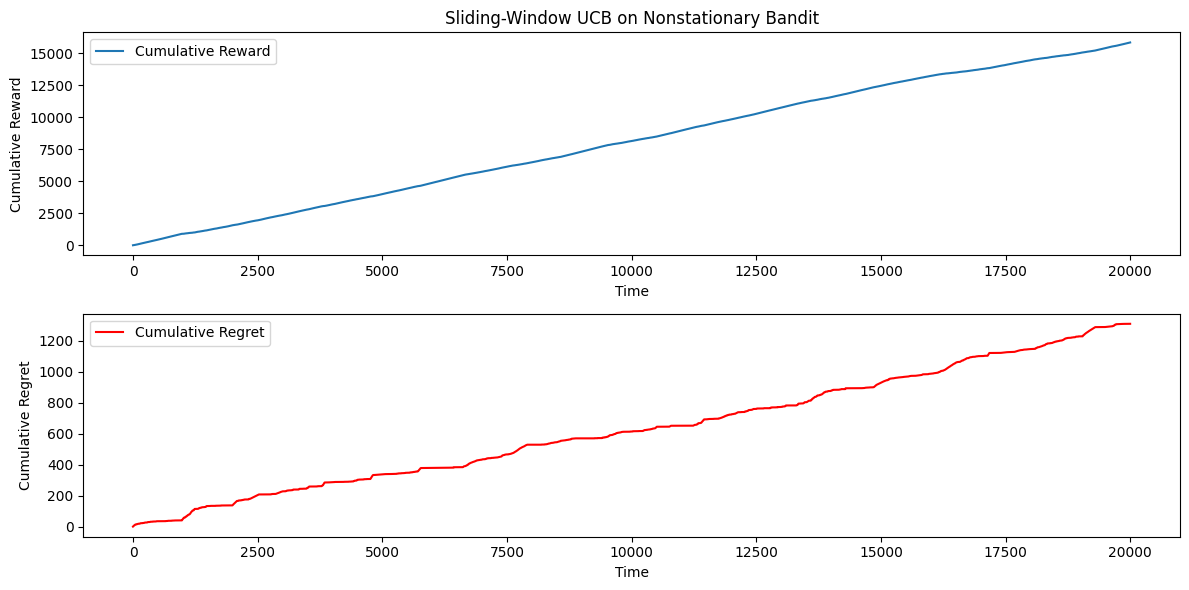

In [ ]:
def simulate(n_arms=5, n_changes=10, horizon=10000, window_size=500, alpha=1.0, seed=42):
    """
    Simulates the nonstationary bandit problem using Sliding-Window UCB.

    Parameters:
    - n_arms: Number of arms.
    - n_changes: Number of changes in the environment.
    - horizon: Total number of time steps.
    - window_size: Sliding window size for the algorithm.
    - alpha: Exploration parameter for UCB.
    - seed: Random seed for reproducibility.

    Returns:
    - cumulative_rewards: Cumulative rewards over time.
    - cumulative_regret: Cumulative regret over time.
    """
    env = NonstationaryBandit(n_arms, n_changes, horizon, seed=seed)
    agent = SlidingWindowUCB(n_arms, window_size, alpha=alpha)

    cumulative_rewards = np.zeros(horizon)
    cumulative_regret = np.zeros(horizon)
    total_reward = 0
    total_regret = 0

    for t in range(horizon):
        arm = agent.select_arm()
        reward = env.step(arm)
        agent.update(arm, reward)

        total_reward += reward
        optimal_reward = env.get_optimal_reward()
        total_regret += optimal_reward - env.probs[arm]

        cumulative_rewards[t] = total_reward
        cumulative_regret[t] = total_regret

        if (t + 1) % (horizon // 10) == 0:
            print(f"Time step {t + 1}/{horizon}")

    return cumulative_rewards, cumulative_regret

# Run the simulation
if __name__ == "__main__":
    n_arms = 5
    n_changes = 20
    horizon = 20000
    window_size = 1000
    alpha = 1.0
    seed = 42

    cumulative_rewards, cumulative_regret = simulate(
        n_arms=n_arms,
        n_changes=n_changes,
        horizon=horizon,
        window_size=window_size,
        alpha=alpha,
        seed=seed
    )

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(cumulative_rewards, label='Cumulative Reward')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title('Sliding-Window UCB on Nonstationary Bandit')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(cumulative_regret, label='Cumulative Regret', color='r')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Regret')
    plt.legend()

    plt.tight_layout()
    plt.show()
